In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
#from sampler import Sampler, result_file
#from lpf_narrowband_dw import LPFC

%run ../src/core.py
%run ../src/lpf.py
%run ../extcore.py
%run -i lpf_narrowband_dw.py

result_file_c = '../results/osiris'
run_name =  '/nb/vkwn_constrained'
seed(0)

N = lambda a: a/median(a)

In [6]:
%run ../src/lpf.py
%run -i lpf_narrowband_dw.py
lpf = LPFC(noise='white', constant_k=False, use_ldtk=False)

In [8]:
Sampler(run_name, lpf, 400, 10, 10)

NameError: global name 'DiffEvol' is not defined

In [7]:
de = DiffEvol(lpf.lnposterior, lpf.ps.bounds, 400, maximize=True, F=0.5, C=0.1)

for i,p in enumerate(lpf.ps.priors[0:4]):
    de._population[:,i] = normal(p.mean, p.std, size=de.n_pop)
    
#for iq in chain(lpf.iq1,lpf.iq2):
#    p = lpf.ps.priors[iq]
#    de._population[:,iq] = normal(p.mean, 2*p.std, size=de.n_pop)
    
de._population[:,unique(lpf.ik2)] = uniform(0.165**2, 0.175**2, size=(de.n_pop, lpf.npb))

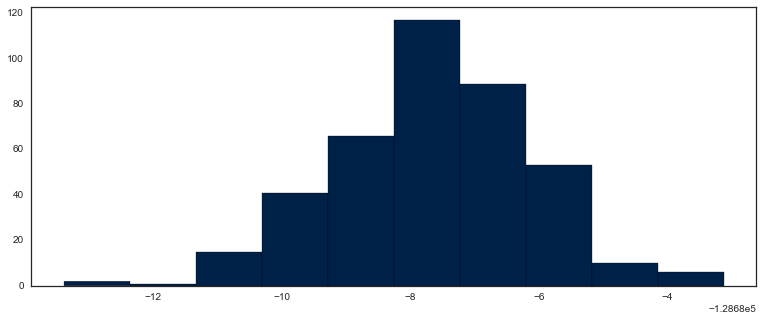

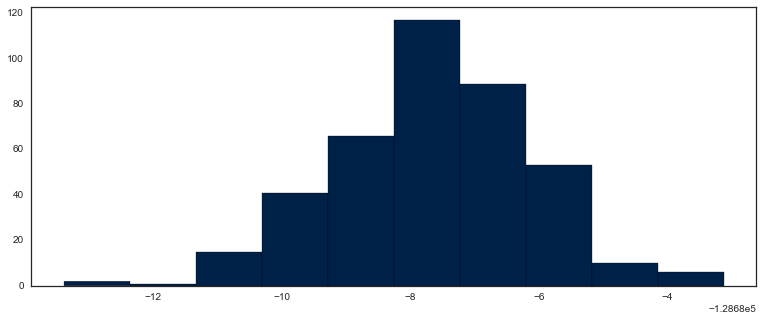

In [21]:
de.F = 0.25
de.C = 0.25
niter = 300
fig,ax = subplots(1,1)

try:
    for i,r in enumerate(de(niter)):
        if ((i+1)%30 == 0) or (i==niter-1):
            ax.cla()
            ax.hist(de._fitness)
            clear_output(wait=True)
            display(HTML('DE Iteration {:4d} max lnlike {:7.1f} med {:7.1f}'.format(i+1,-de.minimum_value,median(-de._fitness))))
            display(fig)
        if ((i+1)%5 == 0) and (i>120):
            for j in range(1):
                ipv = randint(0,high=de.n_pop)
                #pv = fmin(lambda pv: -lpf.lnposterior(pv), de.population[ipv], disp=True)
                #de._population[ipv,:] = pv
except KeyboardInterrupt:
    pass
finally:
    dfde = pd.DataFrame(de.population, columns=lpf.ps.names)
    #dfde.to_hdf(result_file_c,'{:s}/de'.format(run_name))

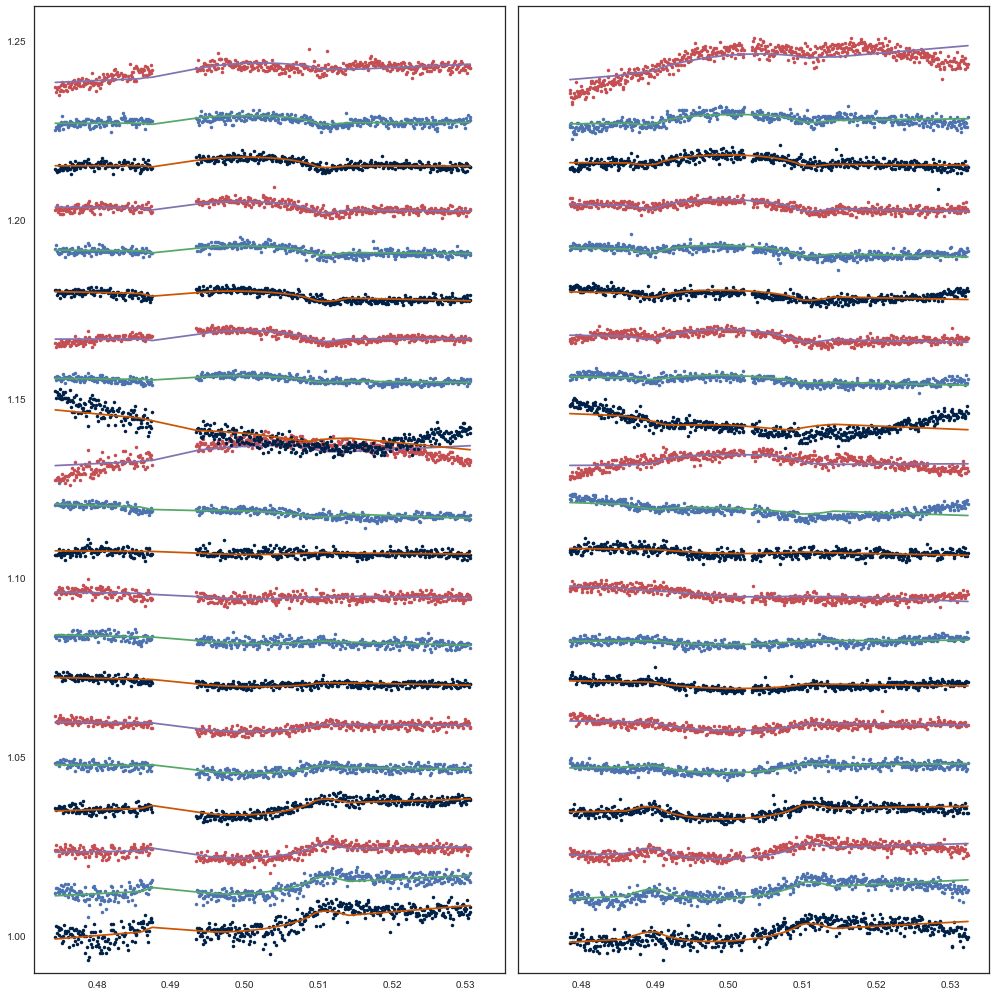

In [22]:
pv = de.minimum_location.copy()
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(1,2,figsize=(14,14), sharey=True, sharex=True)
for i in range(2):
    for j in range(lpf.npb):
        ilc = lpf.npb*i+j
        phase = fold(lpf.times[ilc], pv[1], pv[0], 0.5)
        res = fos[ilc]-fms[ilc]
        axs[i].plot(phase, fos[ilc]+j*0.012, '.')
        axs[i].plot(phase, fms[ilc]+j*0.012)
        #axs[j,i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.99,1.26))
fig.tight_layout()

In [13]:
sampler = EnsembleSampler(de.n_pop, de.n_par, lpf.lnposterior)

In [24]:
sampler.run_mcmc(de.population, 250);

In [14]:
sampler.run_mcmc(chain[:,-1,:], 100);

In [ ]:
sampler.run_mcmc(sampler.chain[:,-1,:], 10000);

In [15]:
for i,s in enumerate(sampler.sample(sampler.chain[:,-1,:], iterations=8000, thin=100)):
    if i%10 == 0:
        clear_output(wait=True)
        display(HTML('%i'%(i+1)))
    if (i%100 == 0) and (i>0):
        dff = pd.DataFrame(sampler.chain[:,:,:].reshape([-1,lpf.ps.ndim]), columns=lpf.ps.names)
        dff.to_hdf(result_file_c,'{:s}/fc_dw'.format(run_name))

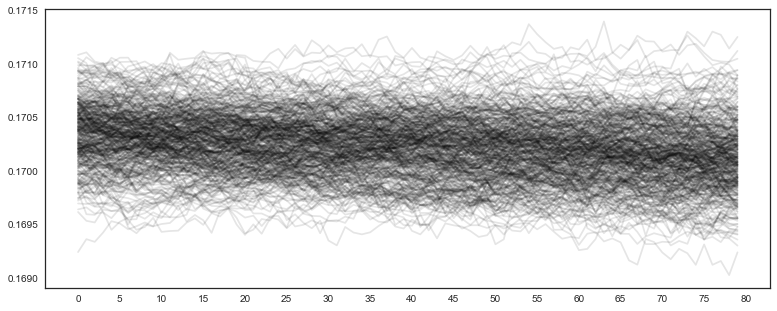

In [17]:
plot(sqrt(sampler.chain[:,100::,6].T), 'k', alpha=0.1);

In [59]:
fc = pd.read_hdf(join('..',result_file), 'vkrn_ldtk/fc')

In [18]:
dff = pd.DataFrame(sampler.chain[:,100:,:].reshape([-1,lpf.ps.ndim]), columns=lpf.ps.names)

In [19]:
dff.to_hdf(result_file_c,'{:s}/fc_dw'.format(run_name))

In [8]:
dff = pd.read_hdf(result_file_c, '{:s}/fc_dw'.format(run_name))

In [9]:
cols = [c for c in dff.columns if 'k2' in c]

In [23]:
chain = dff.values.reshape([400, -1, lpf.ps.ndim])

In [43]:
pbc = [f.c for f in pb_filters_nb]

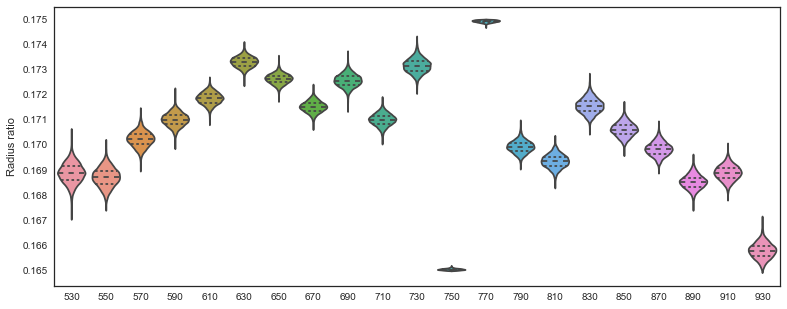

In [46]:
ax = sb.violinplot(sqrt(dff[cols]), inner='quartiles', scale='width')
setp(ax, xticklabels=pbc, ylabel='Radius ratio');

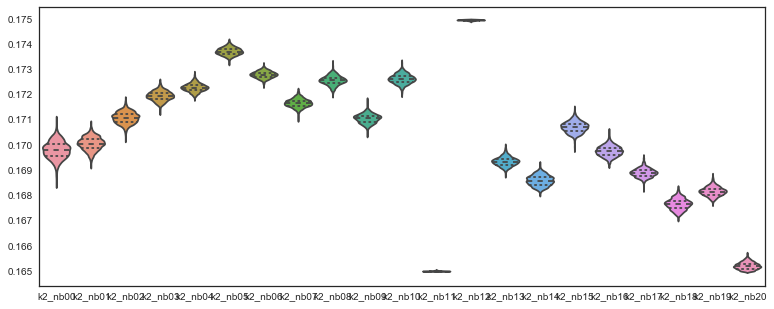

In [22]:
#sb.violinplot(sqrt(fc['k2_g k2_r k2_i k2_z k2_J k2_H k2_K'.split()]), inner=None, color='0.95', linewidth=0, scale='width')
ax = sb.violinplot(sqrt(dff[cols]), inner='quartiles', scale='width')
#setp(ax, xlim=(-0.5,6.5), xticks=arange(7),, ylabel='Radius ratio');

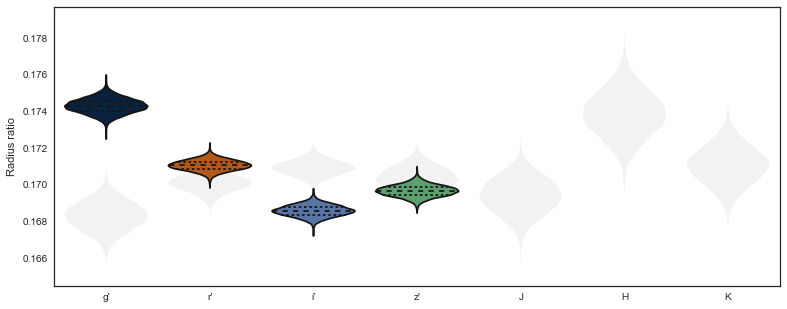

In [123]:
sb.violinplot(sqrt(fc['k2_g k2_r k2_i k2_z k2_J k2_H k2_K'.split()]), inner=None, color='0.95', linewidth=0, scale='width')
ax = sb.violinplot(sqrt(dff['k2_g k2_r k2_i k2_z'.split()]), inner='quartiles', scale='width')
setp(ax, xlim=(-0.5,6.5), xticks=arange(7), xticklabels="g' r' i' z' J H K".split(), ylabel='Radius ratio');

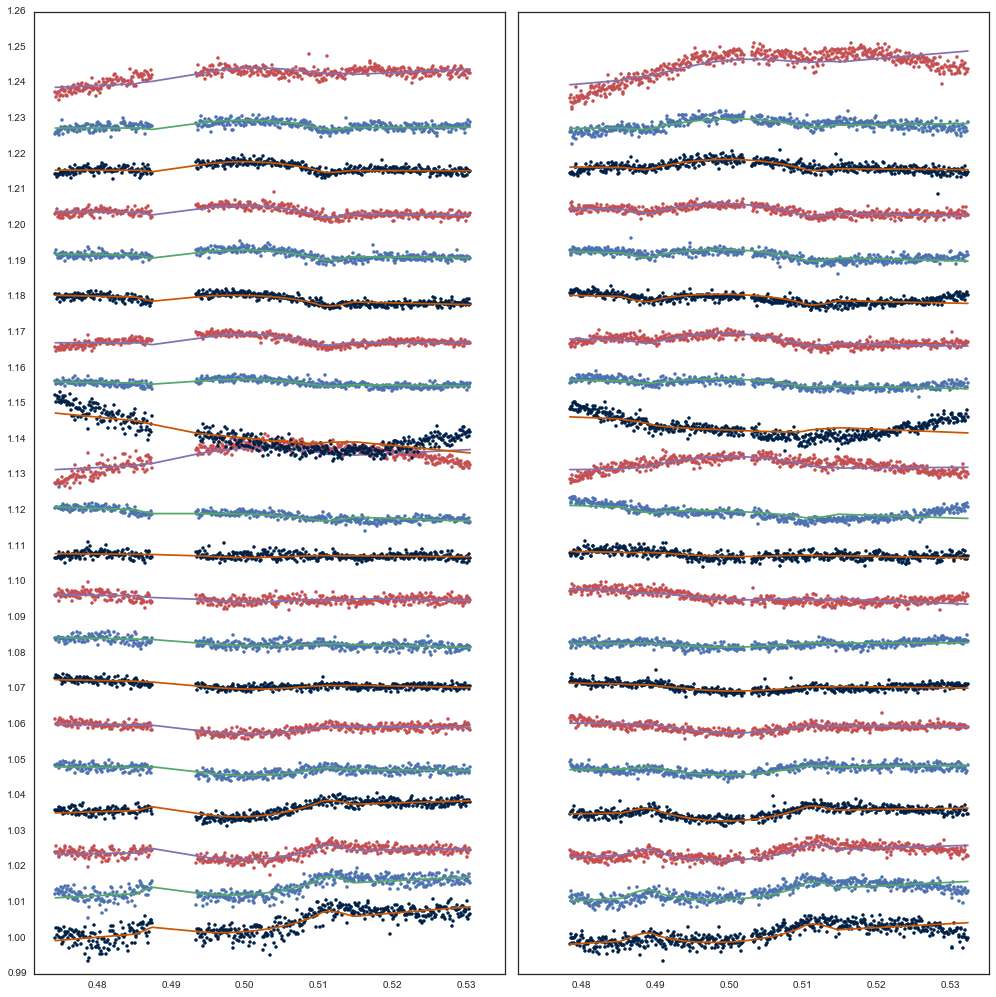

In [37]:
pv = median(chain[:,-1,:],0)
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(1,2,figsize=(14,14), sharey=True, sharex=True)
for i in range(2):
    for j in range(lpf.npb):
        ilc = lpf.npb*i+j
        phase = fold(lpf.times[ilc], pv[1], pv[0], 0.5)
        res = fos[ilc]-fms[ilc]
        axs[i].plot(phase, fos[ilc]+j*0.012, '.')
        axs[i].plot(phase, fms[ilc]+j*0.012)
        #axs[j,i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.99,1.26))
fig.tight_layout()

(-0.01, 0.01)

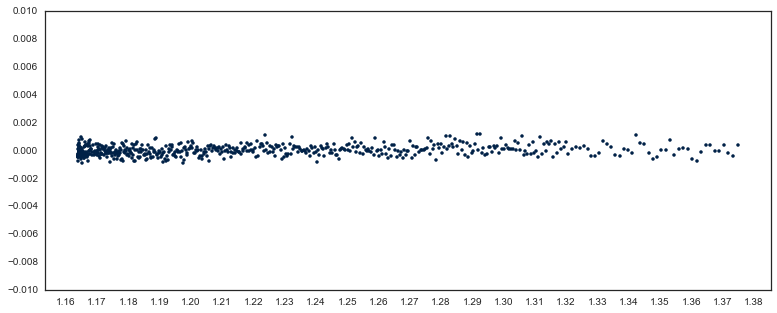

In [118]:
i = 5
plot(lpf.airmass[i], fos[i]-fms[i], '.')
ylim(-0.01,0.01)